In [1]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class DOptimalRegression(BaseEstimator, RegressorMixin):
    """
    Реализация D-оптимальной процедуры поиска коэффициентов регрессии
    по методике В.А. Фатуева и API sklearn.

    Основные шаги:
      1. Итеративный выбор точек (экспериментального плана), максимизирующих определитель информационной матрицы X^T X.
      2. Оценка коэффициентов регрессии методом наименьших квадратов.
      3. Обеспечение совместимости с sklearn API (fit, predict).
    """

    def __init__(self, max_iter=50, tol=1e-6):
        """
        max_iter: максимальное число итераций для выбора точек
        tol: порог изменения определителя для остановки
        """
        self.max_iter = max_iter
        self.tol = tol

    def _update_information_matrix(self, X):
        """Вычисление информационной матрицы M = X^T X"""
        return X.T @ X

    def _d_optimality_criterion(self, M):
        """Определитель информационной матрицы"""
        return np.linalg.det(M)

    def _select_next_point(self, candidates, X_current):
        """
        Выбор точки из кандидатов, максимально увеличивающей |M|
        candidates: матрица кандидатов (n_candidates, n_features)
        X_current: текущий план (n_points, n_features)

        Возвращает индекс выбранной точки и новый определитель
        """
        M_current = self._update_information_matrix(X_current)
        det_current = self._d_optimality_criterion(M_current)

        best_det = det_current
        best_idx = None

        for i, x_new in enumerate(candidates):
            X_new = np.vstack([X_current, x_new])
            M_new = self._update_information_matrix(X_new)
            det_new = self._d_optimality_criterion(M_new)
            if det_new > best_det + self.tol:
                best_det = det_new
                best_idx = i

        return best_idx, best_det

    def fit(self, X, y):
        """
        Обучение модели с D-оптимальным подбором точек.

        X: исходные данные (n_samples, n_features)
        y: целевой вектор (n_samples,)

        Процедура:
        - Инициализация плана из первых точек (например, первые n_features+1 для полноты)
        - Итеративное добавление точек, максимизирующих определитель информационной матрицы
        - Оценка коэффициентов МНК по выбранному плану
        """
        X, y = check_X_y(X, y)
        n_samples, n_features = X.shape

        # Инициализация плана: первые n_features+1 точек (минимум для полноты)
        n_init = n_features + 1
        if n_init > n_samples:
            raise ValueError("Недостаточно точек для инициализации плана")
        X_plan = X[:n_init]
        y_plan = y[:n_init]

        # Кандидаты — все остальные точки
        candidates = X[n_init:]
        candidates_y = y[n_init:]

        prev_det = 0
        for iteration in range(self.max_iter):
            idx, det = self._select_next_point(candidates, X_plan)
            if idx is None or abs(det - prev_det) < self.tol:
                # Нет улучшения или достигнут порог
                break
            # Добавляем выбранную точку в план
            X_plan = np.vstack([X_plan, candidates[idx]])
            y_plan = np.append(y_plan, candidates_y[idx])
            # Удаляем выбранную точку из кандидатов
            candidates = np.delete(candidates, idx, axis=0)
            candidates_y = np.delete(candidates_y, idx, axis=0)
            prev_det = det

        # Оценка коэффициентов МНК по выбранному плану
        # Добавляем столбец единиц для свободного члена
        X_design = np.hstack([np.ones((X_plan.shape[0], 1)), X_plan])
        # Коэффициенты: beta = (X^T X)^(-1) X^T y
        XtX = X_design.T @ X_design
        Xty = X_design.T @ y_plan
        self.coef_ = np.linalg.solve(XtX, Xty)

        self.is_fitted_ = True
        return self

    def predict(self, X):
        """
        Предсказание по обученной модели.
        """
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)
        X_design = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_design @ self.coef_

Оцененные коэффициенты (свободный член + признаки): [302.27531012  88.12260786   3.03525011  25.48727071  35.82969777]
Истинные коэффициенты: [300, 86.47223762550531, 5.6375496650927115, 27.340707193070624, 41.48195023376652]


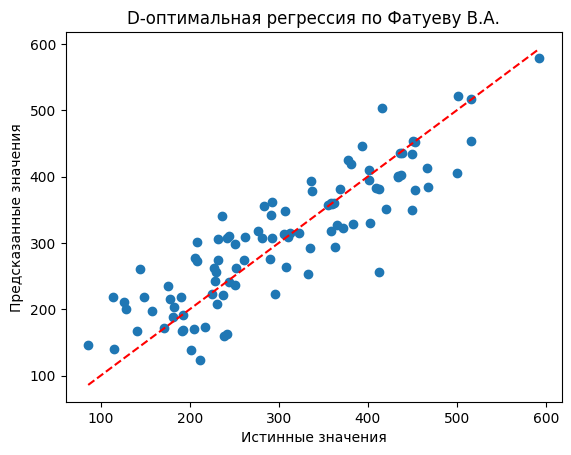

In [2]:
# Пример использования:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    import matplotlib.pyplot as plt
    bias = 300
    # Генерируем данные с 2 признаками
    X, y, coef_true = make_regression(n_samples=100, n_features=4, coef=True, noise=50, random_state=42, bias=bias)

    model = DOptimalRegression(max_iter=int(len(X) / 2))
    model.fit(X, y)
    y_pred = model.predict(X)

    print("Оцененные коэффициенты (свободный член + признаки):", model.coef_)
    print("Истинные коэффициенты:", [bias] + coef_true.tolist())

    plt.scatter(y, y_pred)
    plt.xlabel("Истинные значения")
    plt.ylabel("Предсказанные значения")
    plt.title("D-оптимальная регрессия по Фатуеву В.А.")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.show()

In [4]:
# N/2 samples should be enough to build a regressor